In [1]:
import django
django.setup()

In [2]:
import os
from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q
from django.db.models import Count, Sum, Min, Max, Value
from django.db.models import When, Case, Value
from django.db.models import IntegerField
import numpy as np
import glob
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)
available_dbs = settings.DATABASES.keys()[1:]

# Threads length

In [3]:
# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()

for db in available_dbs:
    os.write(1, db+"\n")
    
        
    # STAGE 1: considering (only) actual threads (must sum 1 for the question)
    threads_length[db] = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values('parentid')\
        .annotate(thread_len_part=Count('parentid'))\
        .values_list('thread_len_part', flat=True)
    # adding 1 to count the question
    threads_length[db] = [x+1 for x in threads_length[db]]
    
    
    # STAGE 2: considering (only) unanswered questions
    # get ids of questions with answers
    parent_questions_ids = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values_list('parentid', flat=True)\
        .distinct()
    # count unanswered questions
    unanswered_q_count = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .exclude(id__in=parent_questions_ids)\
        .count()
    
    # append unanswered q to total counting
    threads_length[db] = threads_length[db] + [1 for i in range(unanswered_q_count)]

'\n::::OLD QUERYies::::\nquestions_id_list = Posts.objects    .using(db)    .filter(posttypeid=1)    .values_list(\'id\', flat=True)\n\nfor question_id in questions_id_list:\n    #os.write(1, str(question_id)+" ")\n    answers_count = Posts.objects     .using(db)    .filter(parentid=question_id)    .count()\n    \n    threads_length[db].append(answers_count + 1)\n'

# Thread length VS Nr threads

In [4]:
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

for db in available_dbs:    
    # count occurences
    bins = np.bincount(threads_length[db])
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes
    }

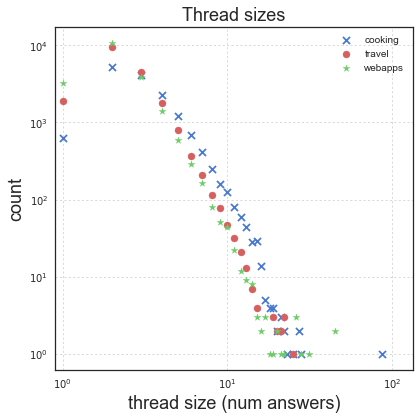

In [5]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count['cooking']['t_sizes'], y=t_length_count['cooking']['t_count'], label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=t_length_count['travel']['t_sizes'], y=t_length_count['travel']['t_count'], label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=t_length_count['webapps']['t_sizes'], y=t_length_count['webapps']['t_count'], label='webapps', s=50, c='g', marker='*', clip_on=False)

ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('Thread sizes', fontsize=18)
ax1.set_xlim(xmin=0.9)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()

# Annotations distribution

In [6]:
base_path = 'annotations_backups/'

# TODO: read from db instead of using CSVs, they might not be updated!!!
# get the latest csv, per db
cooking_path = sorted(glob.glob(base_path + 'cooking_*.csv'))[-1:][0]
travel_path = sorted(glob.glob(base_path + 'travel_*.csv'))[-1:][0]
webapps_path = sorted(glob.glob(base_path + 'webapps_*.csv'))[-1:][0]

cooking_df = pd.read_csv(cooking_path, index_col='id')
travel_df = pd.read_csv(travel_path,  index_col='id')
webapps_df = pd.read_csv(webapps_path,  index_col='id')

cooking_ann_dist = cooking_df.max(axis=1)
travel_ann_dist = travel_df.max(axis=1)
webapps_ann_dist = webapps_df.max(axis=1)

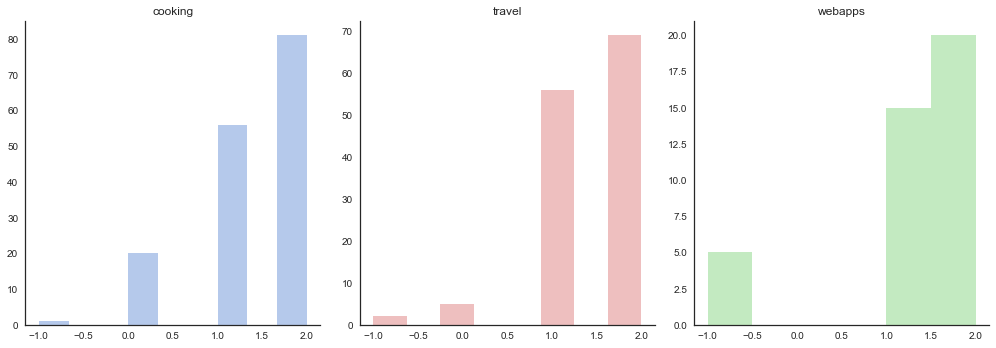

In [7]:
f, axes = plt.subplots(1, 3, figsize=(14, 5))
sns.despine()

g = sns.distplot(a=cooking_ann_dist, kde=False, color="b", ax=axes[0])
g.axes.set_title('cooking')
g = sns.distplot(a=travel_ann_dist, kde=False, color="r", ax=axes[1])
g.axes.set_title('travel')
g = sns.distplot(a=webapps_ann_dist, kde=False, color="g", ax=axes[2])
g.axes.set_title('webapps')

#plt.title('Quality annotations', fontsize=18)

plt.tight_layout()

# Counting of questions/answers, per db

In [8]:
items_counting = {
    'whole_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    },
    'annotated_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    }
}

for db in available_dbs:
    # total nr of questions
    items_counting['whole_data'][db]['questions'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=1) \
            .count()

    # Total nr. of answers
    items_counting['whole_data'][db]['answers'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=2) \
            .count()

    # Total nr. of other posts
    items_counting['whole_data'][db]['other'] = \
        Posts.objects \
            .using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .count()

    # counting annotated questions
    items_counting['annotated_data'][db]['questions'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=1) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

    # counting annotated answers
    items_counting['annotated_data'][db]['answers'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

    # counting annotated others
    items_counting['annotated_data'][db]['others'] = \
        Posts.objects.using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

# whole_data
questions_whole_d = [items_counting['whole_data'][db]['questions'] for db in available_dbs]
answers_whole_d = [items_counting['whole_data'][db]['answers'] for db in available_dbs]
other_whole_d = [items_counting['whole_data'][db]['other'] for db in available_dbs]

# annotated_data
questions_ann_d = [items_counting['annotated_data'][db]['questions'] for db in available_dbs]
answers_ann_d = [items_counting['annotated_data'][db]['answers'] for db in available_dbs]
other_ann_d = [items_counting['annotated_data'][db]['other'] for db in available_dbs]

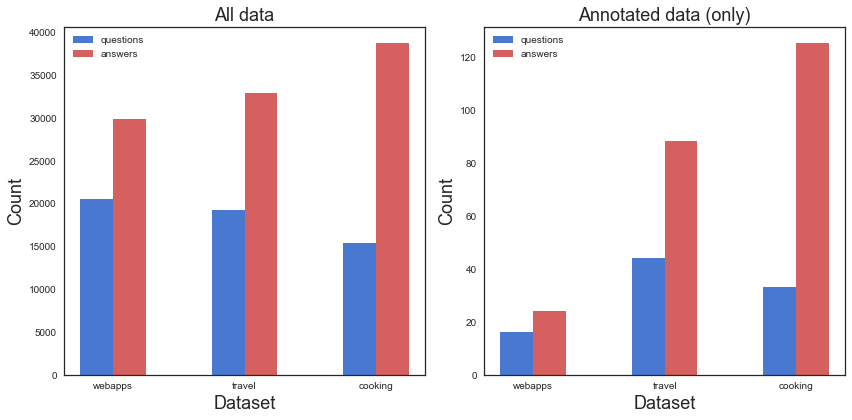

In [9]:
n_groups = 3
bar_width = 0.25
opacity = 1


# whole_data
plt.figure(figsize=(12,6))
plt.subplot(121)
index = np.arange(n_groups)

plt.bar(index, questions_whole_d, bar_width, alpha=opacity, color='b', label='questions')
plt.bar(index + bar_width, answers_whole_d, bar_width, alpha=opacity, color='r', label='answers')
#plt.bar(index + bar_width*2, other_whole_d, bar_width, alpha=opacity, color='g', label='other')

plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('All data', fontsize=18)
plt.xticks(index + bar_width / 2, available_dbs)
plt.legend()
plt.tight_layout()


# annotated_data
plt.subplot(122)
index = np.arange(n_groups)

plt.bar(index, questions_ann_d, bar_width, alpha=opacity, color='b', label='questions')
plt.bar(index + bar_width, answers_ann_d, bar_width, alpha=opacity, color='r', label='answers')
#plt.bar(index + bar_width*2, other_ann_d, bar_width, alpha=opacity, color='g', label='other')

plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Annotated data (only)', fontsize=18)
plt.xticks(index + bar_width / 2, available_dbs)
plt.legend()
plt.tight_layout()

# Nr answers and nr questions, per user

In [10]:
# note: ids are non-negative integers
users_activity = {
    'whole_data': {
        'cooking': {
            # '1': {
            #     'nr_questions': -1,
            #     'nr_answers': -1
            # }   
        },
        'webapps': {},
        'travel': {}
    },
    'annotated_data': {
        'cooking': {},
        'webapps': {},
        'travel': {}
    }
}




for db in available_dbs:
    
    # whole_data
    
    # ex. [{'owneruserid': 17L, 'nr_questions': 13, 'nr_answers': 12}, {...}, {...}]
    whole_d_vals = Posts.objects.using(db)\
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(
            nr_questions=Sum(
            Case(When(posttypeid=1, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField())),
            nr_answers=Sum(
            Case(When(posttypeid=2, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField()))
        )
    
    data = dict()
    for val in whole_d_vals:
        # owneruserid == None if user has been deleted, -1 for wiki entries, see http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
        if val['owneruserid'] >= 1:
            data[val['owneruserid']] = {'nr_questions': val['nr_questions'], 'nr_answers': val['nr_answers']}
    users_activity['whole_data'][db] = data
    
    
    # ONLY annotated_data
    
    # ex. [{'owneruserid': 17L, 'nr_questions': 13, 'nr_answers': 12}, {...}, {...}]
    whole_d_vals = Posts.objects.using(db)\
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(
            nr_questions=Sum(
            Case(When(posttypeid=1, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField())),
            nr_answers=Sum(
            Case(When(posttypeid=2, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField()))
        )
    
    data = dict()
    for val in whole_d_vals:
        # owneruserid == None if user has been deleted, -1 for wiki entries, see http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
        if val['owneruserid'] >= 1:
            data[val['owneruserid']] = {'nr_questions': val['nr_questions'], 'nr_answers': val['nr_answers']}
    users_activity['annotated_data'][db] = data

In [11]:
# extract: each data point is a user, x is #questions, y is #answers
whole_d_cooking = pd.DataFrame.from_dict(users_activity['whole_data']['cooking'], orient='index')
whole_d_travel = pd.DataFrame.from_dict(users_activity['whole_data']['travel'], orient='index')
whole_d_webapps = pd.DataFrame.from_dict(users_activity['whole_data']['webapps'], orient='index')


# TODO: do it also for the annotated_data

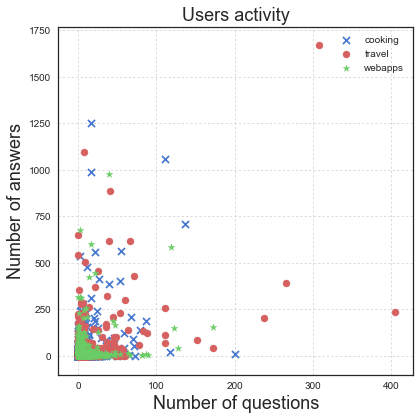

In [12]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=whole_d_cooking['nr_questions'].values, y=whole_d_cooking['nr_answers'].values, label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=whole_d_travel['nr_questions'].values, y=whole_d_travel['nr_answers'].values, label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=whole_d_webapps['nr_questions'].values, y=whole_d_webapps['nr_answers'].values, label='webapps', s=50, c='g', marker='*', clip_on=False)


#TODO: setting log scale causes problems!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#ax1.set_xscale('log', nonposx='mask')
#ax1.set_yscale('log', nonposy='mask')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)


plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()

In [13]:
"""
# Set up the matplotlib figure
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(3, 1, figsize=(12, 7))
sns.despine(left=True)

sns.distplot(a=threads_length['cooking'], kde=False, color="b", ax=axes[0])
sns.distplot(a=threads_length['webapps'], kde=False, color="r", ax=axes[1])
sns.distplot(a=threads_length['travel'], kde=False, color="g", ax=axes[2])
plt.tight_layout()
"""

'\n# Set up the matplotlib figure\nsns.set(style="white", palette="muted", color_codes=True)\nf, axes = plt.subplots(3, 1, figsize=(12, 7))\nsns.despine(left=True)\n\nsns.distplot(a=threads_length[\'cooking\'], kde=False, color="b", ax=axes[0])\nsns.distplot(a=threads_length[\'webapps\'], kde=False, color="r", ax=axes[1])\nsns.distplot(a=threads_length[\'travel\'], kde=False, color="g", ax=axes[2])\nplt.tight_layout()\n'